# Pranav Dev Kottimukkalur Ramasubramanian


# Task 1: User-based Collaborative Filtering


In [1]:
#loading the required packages
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

#importing the necessary data (.dat files)
movies = pd.read_csv('movies.dat', sep='::', engine='python', header=None, names=['Movie_ID', 'Title', 'Genre(s)'], encoding='ISO-8859-1')
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', header=None, names=['User_ID', 'Movie_ID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')
users = pd.read_csv('users.dat', sep='::', engine='python', names=['User_ID', 'Gender', 'Age', 'Occupation', 'Zip_code'], encoding='ISO-8859-1')

In [2]:
#displaying the number of users and movies
user_count = ratings.User_ID.unique().shape[0]
movie_count = ratings.Movie_ID.unique().shape[0]
print(str(user_count) + ' users')
print(str(movie_count) + ' movies')

6040 users
3706 movies


In [3]:
max_movie_count = ratings.Movie_ID.max()

In [4]:
#splitting the dataset to test and train
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(ratings, test_size=0.1) #setting test size to 10%

#training dataset
train_ds = np.zeros((user_count, max_movie_count))
for row in train_df.itertuples():
    train_ds[row[1]-1, row[2]-1] = row[3]-1
train_ds = pd.DataFrame(train_ds)

#testing dataset
test_ds = np.zeros((user_count, max_movie_count))
for row in test_df.itertuples():
    test_ds[row[1]-1, row[2]-1] = row[3]-1
test_ds = pd.DataFrame(test_ds)

In [5]:
cosine_sim = cosine_similarity(train_ds.fillna(0))
#choosing the user as 1 randomly
chosen_user = 1

#initialising a set of 5 K-values
K_values = [1, 15, 30, 45, 60]
EPSILON = 1e-9 #added to avoid division by zero error in the code to make sure the denominator is never zero
data_list = [] #creating a list to store the data
rmse_values = []  #list to store the RMSE values

for K in K_values:
    np_predictions = np.zeros(max_movie_count)

    for j in range(max_movie_count): # j is set as the  index of the current movie
        #Finding the most similar users as the present user except that
        similar_user_ids = np.argsort(cosine_sim[chosen_user])[-(K + 1):-1]
        similar_values = cosine_sim[chosen_user][similar_user_ids]

        #computing average value of the present user's rating
        user_mean = np.sum(train_ds.values[chosen_user]) / (np.sum(np.clip(train_ds.values[chosen_user], 0, 1)) + EPSILON)
        sim_users = train_ds.values[similar_user_ids]
        sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

        #checking if the user has already rated the movies
        if train_ds.iloc[chosen_user, j] != 0:
            np_predictions[j] = train_ds.iloc[chosen_user, j]
        else:
            #selecting the users who have rated the item "j"
            mask_rated_j = sim_users[:, j] > 0

            #calculating the weighted sum of ratings and differences from the mean
            sim_r_sum_mean = similar_values[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])

            #computing the predicted rating
            np_predictions[j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(similar_values[mask_rated_j]) + EPSILON)
            np_predictions[j] = np.clip(np_predictions[j], 0, 5) #validating that the rating are between 0 and 5 only
            np_predictions[j] = np.round(np_predictions[j]) #rounding off the ratings
    data_list.append([chosen_user, K, np_predictions.tolist()])

    
    
    #calculation of RMSE for each K
    squared_diffs = (np_predictions - test_ds.iloc[chosen_user]) ** 2
    mean_squared_diff = np.mean(squared_diffs)
    rmse = np.sqrt(mean_squared_diff)
    rmse_values.append((K, rmse))
    print(f'The user {chosen_user}, with K={K}, has Ratings: {np_predictions} by prediction and RMSE: {rmse}')   

The user 1, with K=1, has Ratings: [3. 3. 3. ... 3. 3. 3.] by prediction and RMSE: 2.990242228147404
The user 1, with K=15, has Ratings: [3. 2. 1. ... 3. 3. 3.] by prediction and RMSE: 2.8893651853113114
The user 1, with K=30, has Ratings: [3. 2. 2. ... 3. 3. 1.] by prediction and RMSE: 2.847729758479188
The user 1, with K=45, has Ratings: [3. 2. 2. ... 3. 3. 3.] by prediction and RMSE: 2.806603693345032
The user 1, with K=60, has Ratings: [3. 2. 2. ... 3. 3. 3.] by prediction and RMSE: 2.767793008454899


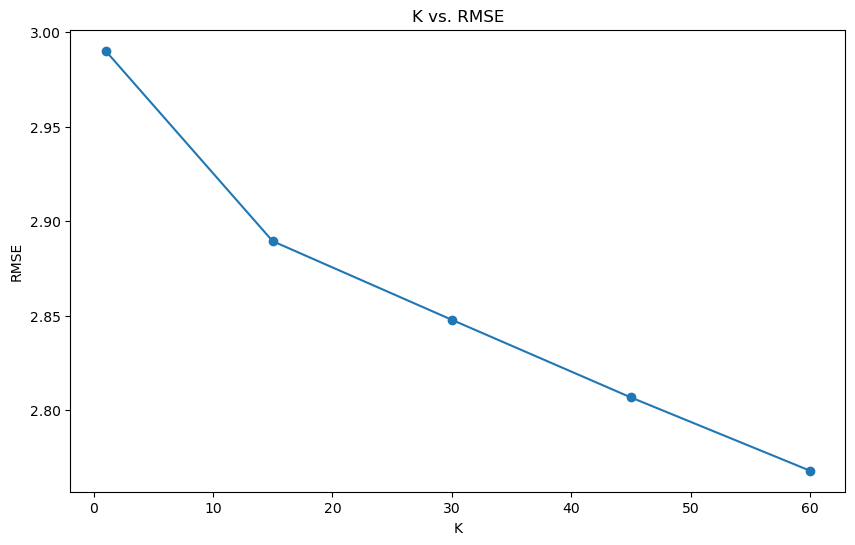

In [6]:
import matplotlib.pyplot as plt

K_values, rmse_values = zip(*rmse_values)

#plot to compare K values and RMSE
plt.figure(figsize=(10, 6))
plt.plot(K_values, rmse_values, marker='o', linestyle='-')
plt.title('K vs. RMSE')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.grid(False)
plt.show()

In [7]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import ndcg_score

#list to store the results
ap_scores = []
ndcg_scores = []

for data in data_list:
    _, _, np_predictions = data  #extracting the predicted ratings

    #getting the original ratings from the training dataset
    original_ratings = train_ds.values[chosen_user]

    #converting to binary for calculation
    threshold = 4 #setting the threshold as 4
    binary_original_ratings = [1 if rating >= threshold else 0 for rating in original_ratings]

    #calculation of AP and NDCG
    ap = average_precision_score(binary_original_ratings, np_predictions)
    ndcg = ndcg_score([binary_original_ratings], [np_predictions])

    ap_scores.append(ap)
    ndcg_scores.append(ndcg)

for i, K in enumerate(K_values):
    print(f"For user {chosen_user}, K={K}:")
    print(f"AP: {ap_scores[i]}")
    print(f"NDCG: {ndcg_scores[i]}")

For user 1, K=1:
AP: 0.6444444444444445
NDCG: 0.8636296023756302
For user 1, K=15:
AP: 0.35365853658536583
NDCG: 0.7176546015906131
For user 1, K=30:
AP: 0.3972602739726027
NDCG: 0.7428186729650574
For user 1, K=45:
AP: 0.3333333333333333
NDCG: 0.7053577951252941
For user 1, K=60:
AP: 0.29591836734693877
NDCG: 0.6816222912719323


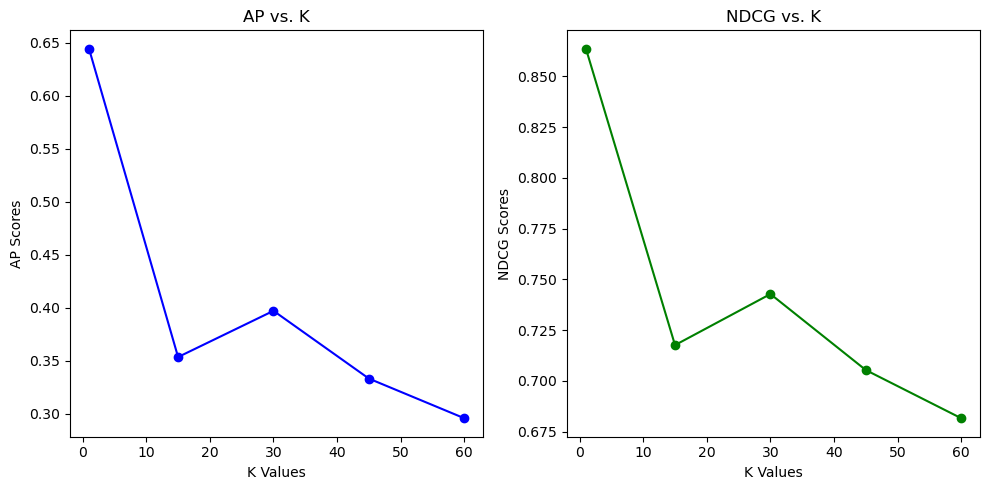

In [8]:
import matplotlib.pyplot as plt

#AP scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K_values, ap_scores, marker='o', linestyle='-', color='b')
plt.title('AP vs. K')
plt.xlabel('K Values')
plt.ylabel('AP Scores')
plt.grid(False)

#NDCG scores
plt.subplot(1, 2, 2)
plt.plot(K_values, ndcg_scores, marker='o', linestyle='-', color='g')
plt.title('NDCG vs. K')
plt.xlabel('K Values')
plt.ylabel('NDCG Scores')
plt.grid(False)

plt.tight_layout()
plt.show()

In [9]:
# Calculate the average AP and NDCG values
ap_KNNCF = sum(ap_scores) / len(ap_scores)
ndcg_KNNCF = sum(ndcg_scores) / len(ndcg_scores)

# Print the average results
print(f"For user {chosen_user}:")
print(f"Average AP: {ap_KNNCF}")
print(f"Average NDCG: {ndcg_KNNCF}")

For user 1:
Average AP: 0.404922991136537
Average NDCG: 0.7422165926657054


In [10]:
columns = ["User_ID", "K", "Predicted Ratings"]
ratings_df = pd.DataFrame(data_list, columns=columns)
ratings_df

,User_ID,K,Predicted Ratings
0,1,1,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ..."
1,1,15,"[3.0, 2.0, 1.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, ..."
2,1,30,"[3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 3.0, 1.0, ..."
3,1,45,"[3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, ..."
4,1,60,"[3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, ..."


In [11]:
labels = test_ds.values

#Calculation of RMSE
squared_error = np.square(np_predictions - labels)
weight = np.clip(labels, 0, 1)
squared_error = squared_error * weight

RMSE_KNNCF = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE for User-based Collaborative Filtering Testing Dataset: " + str(RMSE_KNNCF));

RMSE for User-based Collaborative Filtering Testing Dataset: 1.0168024242316116


# Task 2: Item-based Filtering

### Pearson correlation

In [12]:
DELTA = 25 #for significance weighting
EPSILON = 1e-9

np_movie_pearson_corr = np.zeros((user_count, max_movie_count))

# setting i and j to iterate over pairs of items to calculate Pearson correlation between possible pairs of items(movies) using a nested loop
for i, i_vec in enumerate(train_ds.T.values):
    for j, j_vec in enumerate(train_ds.T.values):

        # mask_i and mask_j are used to determine users who have rated each item(movie)
        mask_i = i_vec > 0 
        mask_j = j_vec > 0

        #setting to skip if there are no correlated values
        corrated_index = np.intersect1d(np.where(mask_i), np.where(mask_j))
        if len(corrated_index) == 0:
            continue

        # average value of i_vec and j_vec
        i_mean = np.sum(i_vec) / (np.sum(np.clip(i_vec, 0, 1)) + EPSILON)
        j_mean = np.sum(j_vec) / (np.sum(np.clip(j_vec, 0, 1)) + EPSILON)

        #computing pearson correlation
        i_sub_mean = i_vec[corrated_index] - i_mean
        j_sub_mean = j_vec[corrated_index] - j_mean
        
        #calculating the squared difference between the user's rating and the mean rating for user i.
        i_sub_sq = np.square(i_sub_mean)
        #calculating the squared difference between the item's rating and the mean rating for item j.
        j_sub_sq = np.square(j_sub_mean)

        i_sub_sq_sum_sqrt = np.sqrt(np.sum(i_sub_sq))
        j_sub_sq_sum_sqrt = np.sqrt(np.sum(j_sub_sq))

        similarity = np.sum(i_sub_mean * j_sub_mean) / (i_sub_sq_sum_sqrt * j_sub_sq_sum_sqrt + EPSILON)

        #significance weighting
        weighted_similarity = (min(len(corrated_index), DELTA) / DELTA) * similarity

        np_movie_pearson_corr[i][j] = weighted_similarity
        
np_movie_pearson_corr #displaying the correlation matrix

array([[ 1.        ,  0.11409056,  0.12203464, ...,  0.30198136,
         0.11666543,  0.09572378],
       [ 0.11409056,  1.        ,  0.01511666, ..., -0.16852877,
        -0.04198369,  0.08655972],
       [ 0.12203464,  0.01511666,  1.        , ...,  0.10243391,
        -0.08      ,  0.36587866],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [13]:
import numpy as np
#choosing a random movie id
chosen_movie = np.random.choice(max_movie_count)  

# Defining K and epsilon
K = 10
EPSILON = 1e-9

#predicted ratings
movie_predictions = np.zeros(user_count)

#finding top K most similar items to the chosen item except itself
similar_item_ids = np.argsort(np_movie_pearson_corr[chosen_movie])[-(K + 1):-1]
#calculating coefficient of the similar items
similar_values = np_movie_pearson_corr[chosen_movie][similar_item_ids]
#calculating the average value of the chosen item's ratings
similar_items = train_ds.T.values[similar_item_ids]
item_mean = np.sum(train_ds.T.values[chosen_movie]) / (np.sum(np.clip(train_ds.T.values[chosen_movie], 0, 1)) + EPSILON)
similar_items_mean = np.sum(similar_items, axis=1) / (np.sum(np.clip(similar_items, 0, 1), axis=1) + EPSILON)

#iterating through users to predict their rting for the item
for user_index in range(user_count):
    if train_ds.T.values[chosen_movie][user_index] == 0:
        # Calculate the weighted sum of ratings and differences from mean
        similar_ratings_sum_mean = similar_values * (similar_items[:, user_index] - similar_items_mean)
        
        # Filter unrated items
        w = np.clip(similar_items[:, user_index], 0, 1)
        similar_ratings_sum_mean *= w

        if np.sum(similar_values) == 0:
            movie_predictions[user_index] = item_mean
        else:
            movie_predictions[user_index] = item_mean + np.sum(similar_ratings_sum_mean) / (np.sum(similar_values) + EPSILON)

        movie_predictions[user_index] = np.clip(movie_predictions[user_index], 0, 5)
        movie_predictions[user_index] = np.round(movie_predictions[user_index])
        
        # Display the predicted rating for user_index
        print(f"Predicted rating for User {user_index} on Movie {chosen_movie}: {movie_predictions[user_index]}")

Predicted rating for User 0 on Movie 3241: 3.0
Predicted rating for User 1 on Movie 3241: 3.0
Predicted rating for User 2 on Movie 3241: 3.0
Predicted rating for User 3 on Movie 3241: 3.0
Predicted rating for User 4 on Movie 3241: 3.0
Predicted rating for User 5 on Movie 3241: 3.0
Predicted rating for User 6 on Movie 3241: 3.0
Predicted rating for User 7 on Movie 3241: 3.0
Predicted rating for User 8 on Movie 3241: 3.0
Predicted rating for User 9 on Movie 3241: 3.0
Predicted rating for User 10 on Movie 3241: 3.0
Predicted rating for User 11 on Movie 3241: 3.0
Predicted rating for User 12 on Movie 3241: 3.0
Predicted rating for User 13 on Movie 3241: 3.0
Predicted rating for User 14 on Movie 3241: 3.0
Predicted rating for User 15 on Movie 3241: 3.0
Predicted rating for User 16 on Movie 3241: 3.0
Predicted rating for User 17 on Movie 3241: 3.0
Predicted rating for User 18 on Movie 3241: 3.0
Predicted rating for User 19 on Movie 3241: 3.0
Predicted rating for User 20 on Movie 3241: 3.0
Pr

In [14]:
labels = test_ds.T.values

#RMSE calculation
squared_error = np.square(movie_predictions - labels)
weight = np.clip(labels, 0, 1)
squared_error = squared_error * weight

# RMSE
RMSE_pearson = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE for Item-based CF using Pearson Correlation: " + str(RMSE_pearson));

RMSE for Item-based CF using Pearson Correlation: 0.9894325723145757


### Cosine Similarity

In [15]:
#calculating item-item cosine similarity
item_cosine_similarity = cosine_similarity(train_ds.T)

#choosing the same movie from pearson correlation for better comparison
chosen_movie_index = chosen_movie

#setting k as 10 similarly
K = 10
EPSILON = 1e-9

#array to store predictions
np_predictions_cosine = np.zeros(user_count)

# Find the top-K most similar items to the random item (excluding itself) using cosine similarity
similar_item_ids = np.argsort(item_cosine_similarity[chosen_movie_index])[-(K + 1):-1]

# Calculating the coefficient values of similar items (cosine similarities)
similar_values = item_cosine_similarity[chosen_movie_index][similar_item_ids]

# Calculating the average value of the random item's ratings
similar_items = train_ds.T.values[similar_item_ids]
item_mean = np.sum(train_ds.T.values[chosen_movie_index]) / (np.sum(np.clip(train_ds.T.values[chosen_movie_index], 0, 1)) + EPSILON)
similar_items_mean = np.sum(similar_items, axis=1) / (np.sum(np.clip(similar_items, 0, 1), axis=1) + EPSILON)

#Iterating through users to predict their ratings for the random item
for user_index in range(user_count):
    if train_ds.T.values[chosen_movie_index][user_index] == 0:
        # Calculating the weighted sum of ratings and differences from mean
        similar_ratings_sum_mean = similar_values * (similar_items[:, user_index] - similar_items_mean)
        
        #Filtering unrated items
        w = np.clip(similar_items[:, user_index], 0, 1)
        similar_ratings_sum_mean *= w

        if np.sum(similar_values) == 0:
            np_predictions_cosine[user_index] = item_mean
        else:
            np_predictions_cosine[user_index] = item_mean + np.sum(similar_ratings_sum_mean) / (np.sum(similar_values) + EPSILON)

        np_predictions_cosine[user_index] = np.clip(np_predictions_cosine[user_index], 0, 5)
        np_predictions_cosine[user_index] = np.round(np_predictions_cosine[user_index])
        
for user_index in range(user_count):
    predicted_rating = np_predictions_cosine[user_index]
    print(f"User {user_index}: Predicted Rating for Movie {chosen_movie_index}: {predicted_rating:.2f}")

User 0: Predicted Rating for Movie 3241: 3.00
User 1: Predicted Rating for Movie 3241: 3.00
User 2: Predicted Rating for Movie 3241: 3.00
User 3: Predicted Rating for Movie 3241: 3.00
User 4: Predicted Rating for Movie 3241: 3.00
User 5: Predicted Rating for Movie 3241: 3.00
User 6: Predicted Rating for Movie 3241: 3.00
User 7: Predicted Rating for Movie 3241: 3.00
User 8: Predicted Rating for Movie 3241: 3.00
User 9: Predicted Rating for Movie 3241: 3.00
User 10: Predicted Rating for Movie 3241: 3.00
User 11: Predicted Rating for Movie 3241: 3.00
User 12: Predicted Rating for Movie 3241: 3.00
User 13: Predicted Rating for Movie 3241: 3.00
User 14: Predicted Rating for Movie 3241: 3.00
User 15: Predicted Rating for Movie 3241: 3.00
User 16: Predicted Rating for Movie 3241: 3.00
User 17: Predicted Rating for Movie 3241: 3.00
User 18: Predicted Rating for Movie 3241: 3.00
User 19: Predicted Rating for Movie 3241: 3.00
User 20: Predicted Rating for Movie 3241: 3.00
User 21: Predicted Rati

In [16]:
labels = test_ds.T.values

#RMSE calculation
squared_error = np.square(np_predictions_cosine - labels)
weight = np.clip(labels, 0, 1)
squared_error = squared_error * weight

RMSE_cosine = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE for Item-based Collaborative Filtering using Cosine Similarity: " + str(RMSE_cosine));

RMSE for Item-based Collaborative Filtering using Cosine Similarity: 0.9934031976543164


In [18]:
### inference ###
if RMSE_pearson > RMSE_cosine:
    print('The RMSE for Cosine Similarity is lower, indicating that it performs better for predicting user ratings for the chosen movie.')
else:
    print('The RMSE for Pearson Correlation is lower, indicating that it performs better for predicting user ratings for the chosen movie.')

The RMSE for Pearson Correlation is lower, indicating that it performs better for predicting user ratings for the chosen movie.


# Task 3: A Better Recommender System

## Task 3.1 : A better system

In [19]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

#creating surprise dataset from pandas
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['User_ID', 'Movie_ID', 'Rating']], reader)

#splitting the newly created dataset into train and test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)#setting test size and random state

#initialising  and training the SVD model
model = SVD()
model.fit(trainset)

#predicting for the testing set
predictions = model.test(testset)

#RMSE Calculation
rmse_Option1RecSys = accuracy.rmse(predictions)
print(f'RMSE: {rmse_Option1RecSys}')

RMSE: 0.8736
RMSE: 0.8736043565756632


In [20]:
#Recommending movies for a random user
user_id = np.random.choice(ratings['User_ID'].unique()) #selecting a random user and reecommending movies to that user
user_items = set(ratings[ratings['User_ID'] == user_id]['Movie_ID']) #movies the user has already rated are stored here
anti_testset = trainset.build_anti_testset(fill=0) #This stores all the mvie ratings that the user didnt rate by setting the rating as '0'
user_recommendations = model.test(anti_testset)

#Recommending the top 10 for the selected random user
N = 10
user_recommendations.sort(key=lambda x: x.est, reverse=True) #sorting the previous list in descending order based on estimated ratings
top_N_recommendations = [x for x in user_recommendations if x.iid not in user_items][:N]

#The top 10 movies for the user
for recommendation in top_N_recommendations:
    movie_title = movies[movies['Movie_ID'] == recommendation.iid]['Title'].values[0]
    print(f'User ID {user_id}:')
    print(f'Recommended Movie: {movie_title}, Predicted Rating: {recommendation.est}')

User ID 4149:
Recommended Movie: Star Wars: Episode IV - A New Hope (1977), Predicted Rating: 5
User ID 4149:
Recommended Movie: Double Indemnity (1944), Predicted Rating: 5
User ID 4149:
Recommended Movie: Usual Suspects, The (1995), Predicted Rating: 5
User ID 4149:
Recommended Movie: Cinema Paradiso (1988), Predicted Rating: 5
User ID 4149:
Recommended Movie: Rosencrantz and Guildenstern Are Dead (1990), Predicted Rating: 5
User ID 4149:
Recommended Movie: North by Northwest (1959), Predicted Rating: 5
User ID 4149:
Recommended Movie: Star Wars: Episode IV - A New Hope (1977), Predicted Rating: 5
User ID 4149:
Recommended Movie: Maltese Falcon, The (1941), Predicted Rating: 5
User ID 4149:
Recommended Movie: Wizard of Oz, The (1939), Predicted Rating: 5
User ID 4149:
Recommended Movie: Singin' in the Rain (1952), Predicted Rating: 5


In [21]:
# AP and NDCG calculation:
from sklearn.metrics import average_precision_score
from sklearn.metrics import ndcg_score
actual_ratings = [recommendation.est for recommendation in top_N_recommendations]
threshold = 4
binary_relevance = [1 if rating >= threshold else 0 for rating in actual_ratings]
ap_Option1RecSys = average_precision_score(binary_relevance, actual_ratings)
print(f'AP: {ap_Option1RecSys}')
relevance_matrix = [[1] if rating >= threshold else [0] for rating in actual_ratings]
true_relevance = binary_relevance
ndcg_Option1RecSys = ndcg_score([true_relevance], [actual_ratings])
print(f'NDCG: {ndcg_Option1RecSys}')


AP: 1.0
NDCG: 1.0


## Task 3.2 : MovieAvg

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score, ndcg_score

#Calculation of average rating of each movie
movie_avg_ratings = ratings.groupby('Movie_ID')['Rating'].mean().reset_index()
movie_avg_ratings = movie_avg_ratings.rename(columns={'Rating': 'Average_Rating'})

#sorting in descending order
sorted_movies = movie_avg_ratings.sort_values(by='Average_Rating', ascending=False)

#representing the movie as a binary matrix
user_movie_ratings = pd.pivot_table(ratings, values='Rating', index='User_ID', columns='Movie_ID').fillna(0).to_numpy()
binary_user_movie_ratings = (user_movie_ratings > 0).astype(int)

#finding users who rated more than 100 movies
user_ratings_count = binary_user_movie_ratings.sum(axis=1)
active_users = np.where(user_ratings_count > 100)[0]

#selecting 5 random users from above
if len(active_users) >= 5:
    selected_users = np.random.choice(active_users, 5, replace=False)

    #creating a dictionary to verify Movie_ID to movie titles
    movie_id_to_title = dict(zip(movies['Movie_ID'], movies['Title']))

    for user_id in selected_users:
        #suggesting top 30 movies for each user
        recommended_movies = sorted_movies.head(30)
        recommended_movie_ids = recommended_movies['Movie_ID']

        user_name = users[users['User_ID'] == user_id]['User_ID'].values[0]

        #displaying the 30 recommended movies for each user along with the ratings
        print(f"\nTop 30 Movies Recommended for User {user_id} (ID: {user_id}) based on Highest Average Ratings: \n")
        for movie_id in recommended_movie_ids:
            movie_title = movie_id_to_title.get(movie_id, 'Unknown')
            average_rating = sorted_movies[sorted_movies['Movie_ID'] == movie_id]['Average_Rating'].values[0]
            print(f"Movie Title: {movie_title}, Average Rating: {average_rating:.2f}")

else:
    print("There are fewer than 5 users who have rated more than 100 movies.")



Top 30 Movies Recommended for User 1181 (ID: 1181) based on Highest Average Ratings: 

Movie Title: Schlafes Bruder (Brother of Sleep) (1995), Average Rating: 5.00
Movie Title: Bittersweet Motel (2000), Average Rating: 5.00
Movie Title: Follow the Bitch (1998), Average Rating: 5.00
Movie Title: Song of Freedom (1936), Average Rating: 5.00
Movie Title: Gate of Heavenly Peace, The (1995), Average Rating: 5.00
Movie Title: Baby, The (1973), Average Rating: 5.00
Movie Title: One Little Indian (1973), Average Rating: 5.00
Movie Title: Smashing Time (1967), Average Rating: 5.00
Movie Title: Ulysses (Ulisse) (1954), Average Rating: 5.00
Movie Title: Lured (1947), Average Rating: 5.00
Movie Title: I Am Cuba (Soy Cuba/Ya Kuba) (1964), Average Rating: 4.80
Movie Title: Lamerica (1994), Average Rating: 4.75
Movie Title: Apple, The (Sib) (1998), Average Rating: 4.67
Movie Title: Sanjuro (1962), Average Rating: 4.61
Movie Title: Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954), 

In [23]:
from sklearn.metrics import mean_squared_error

#list to store each result for a user
user_aps = []
user_ndcgs = []
user_rmses = []

for user_id in selected_users:
    #recommendations and AP and NDCG calculations
    recommendations = np.argsort(user_movie_ratings[user_id])[::-1]
    original_ratings = binary_user_movie_ratings[user_id]

    ap_user = average_precision_score(original_ratings, recommendations)
    ndcg_user = ndcg_score([original_ratings], [recommendations], k=30)

    #RMSE
    predicted_ratings = user_movie_ratings[user_id]
    rmse_user = mean_squared_error(original_ratings, predicted_ratings, squared=False)

    #appending the user results
    user_aps.append(ap_user)
    user_ndcgs.append(ndcg_user)
    user_rmses.append(rmse_user)

#calculating the overall metrics
ap_MovieAvg = np.mean(user_aps)
ndcg_MovieAvg = np.mean(user_ndcgs)
RMSE_MovieAvg = np.mean(user_rmses)

# Display the results for each user
user_results = pd.DataFrame({
    "UserID": selected_users,
    "AP": user_aps,
    "NDCG": user_ndcgs,
    "RMSE": user_rmses
})
print(user_results)

#overall metrics
overall_results = pd.DataFrame({
    "Overall Metrics": ["AP", "NDCG", "RMSE"],
    "Value": [ap_MovieAvg, ndcg_MovieAvg, RMSE_MovieAvg]
})
print("\nSummary:")
print(overall_results)

   UserID        AP      NDCG      RMSE
0    1181  0.094019  0.101787  0.828851
1    5670  0.021767  0.000000  0.611546
2    4797  0.028376  0.027288  0.478631
3      30  0.031581  0.022705  0.522303
4    1205  0.040046  0.059116  0.562116

Summary:
  Overall Metrics     Value
0              AP  0.043158
1            NDCG  0.042179
2            RMSE  0.600689


# Comparing the AP, NDCG and RMSE of three models

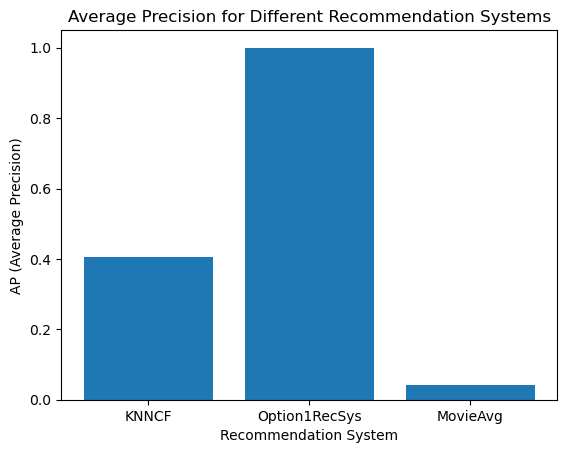

In [24]:
import matplotlib.pyplot as plt

#Average Precision Data
ap_values = [ap_KNNCF, ap_Option1RecSys, ap_MovieAvg]  # Replace with your actual values
recommendation_systems = ['KNNCF', 'Option1RecSys', 'MovieAvg']

#graph to display results based on AP
plt.bar(recommendation_systems, ap_values)
plt.xlabel('Recommendation System')
plt.ylabel('AP (Average Precision)')
plt.title('Average Precision for Different Recommendation Systems')
plt.show()


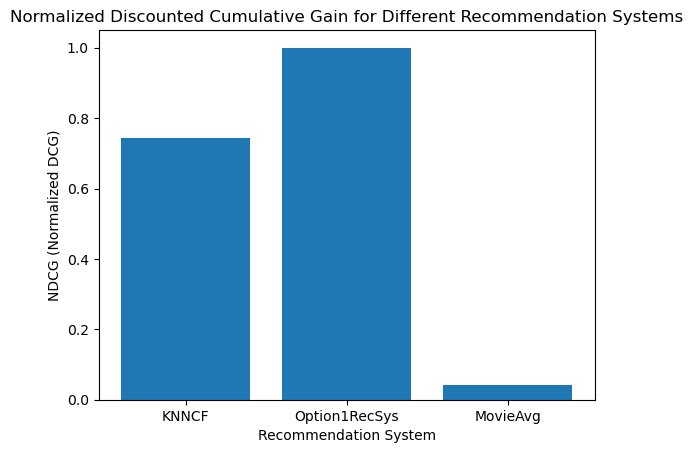

In [25]:
#Normalized Discounted Cumulative Gain Data
ndcg_values = [ndcg_KNNCF, ndcg_Option1RecSys, ndcg_MovieAvg]  # Replace with your actual values

#graph to display results based on NDCG
plt.bar(recommendation_systems, ndcg_values)
plt.xlabel('Recommendation System')
plt.ylabel('NDCG (Normalized DCG)')
plt.title('Normalized Discounted Cumulative Gain for Different Recommendation Systems')
plt.show()

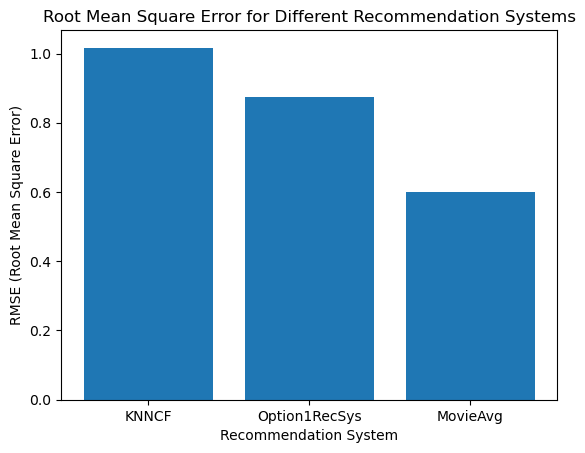

In [26]:
#Root Mean Square Error data
rmse_values = [RMSE_KNNCF, rmse_Option1RecSys, RMSE_MovieAvg]  # Replace with your actual values

#graph to display results based on RMSE
plt.bar(recommendation_systems, rmse_values)
plt.xlabel('Recommendation System')
plt.ylabel('RMSE (Root Mean Square Error)')
plt.title('Root Mean Square Error for Different Recommendation Systems')
plt.show()

## Defining the best model

In [27]:
import plotly.graph_objects as go

#Composite score for finding the best model (AP + NDCG) - RMSE:
composite_scores = [(ap + ndcg) - rmse for ap, ndcg, rmse in zip(ap_values, ndcg_values, rmse_values)]

recommendation_systems = ['KNNCF', 'Option1RecSys', 'MovieAvg']

#interactive bar chart using plotly
fig = go.Figure(data=[
    go.Bar(
        x=recommendation_systems,
        y=composite_scores,
        marker=dict(color=np.where(np.array(composite_scores) >= 0, 'green', 'red')),
    )
])

fig.update_layout(
    title='Composite Score [ (AP + NDCG) - RMSE ] for Different Recommendation Systems',
    xaxis_title='Recommendation System',
    yaxis_title='Composite Score'
)

fig.show()

In [28]:
best_model_index = np.argmax(composite_scores)
best_model = recommendation_systems[best_model_index]
best_score = composite_scores[best_model_index]

print(f"The best model is {best_model} with a composite score of {best_score:.2f}")

The best model is Option1RecSys with a composite score of 1.13
